# Predicting house prices using k-nearest neighbors regression
In this notebook, you will implement k-nearest neighbors regression. You will:
  * Find the k-nearest neighbors of a given query input
  * Predict the output for the query input using the k-nearest neighbors
  * Choose the best value of k using a validation set

# Fire up Turi Create

In [1]:
import turicreate

# Load in house sales data

For this notebook, we use a subset of the King County housing dataset created by randomly selecting 40% of the houses in the full dataset.

In [2]:
sales = turicreate.SFrame('home_data_small.sframe/')

# Import useful functions from previous notebooks

To efficiently compute pairwise distances among data points, we will convert the SFrame into a 2D Numpy array. First import the numpy library and then copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [3]:
import numpy as np # note this allows us to refer to numpy as np instead

In [4]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe  = data_sframe[features]
    
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]

    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

We will also need the `normalize_features()` function from Week 5 that normalizes all feature columns to unit norm. Paste this function below.

In [5]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = feature_matrix/norms
    return(normalized_features, norms)

# Split data into training, test, and validation sets

In [6]:
(train_and_validation, test) = sales.random_split(.8, seed=1) # initial train/test split
(train, validation) = train_and_validation.random_split(.8, seed=1) # split training set into training and validation sets

# Extract features and normalize

Using all of the numerical inputs listed in `feature_list`, transform the training, test, and validation SFrames into Numpy arrays:

In [7]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

In computing distances, it is crucial to normalize features. Otherwise, for example, the `sqft_living` feature (typically on the order of thousands) would exert a much larger influence on distance than the `bedrooms` feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.

IMPORTANT: Make sure to store the norms of the features in the training set. The features in the test and validation sets must be divided by these same norms, so that the training, test, and validation sets are normalized consistently.

In [8]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

# Compute a single distance

To start, let's just explore computing the "distance" between two given houses.  We will take our **query house** to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

To see the features associated with the query house, print the first row (index 0) of the test feature matrix. You should get an 18-dimensional vector whose components are between 0 and 1.

In [9]:
features_test

array([[ 0.01345102,  0.01551285,  0.01807473, ..., -0.01346927,
         0.01375926,  0.0016225 ],
       [ 0.01345102,  0.01551285,  0.00602491, ..., -0.01346568,
         0.01035159,  0.00174419],
       [ 0.01345102,  0.01163464,  0.01054359, ..., -0.01346136,
         0.00977293,  0.00252907],
       ...,
       [ 0.01345102,  0.00775643,  0.01355605, ..., -0.01343598,
         0.00797265,  0.00030422],
       [ 0.01345102,  0.01551285,  0.02108718, ..., -0.01344907,
         0.01832425,  0.00231531],
       [ 0.01345102,  0.01163464,  0.01054359, ..., -0.01342818,
         0.00848702,  0.00458478]])

In [10]:
features_test[0:1].shape

(1, 18)

Now print the 10th row (index 9) of the training feature matrix. Again, you get an 18-dimensional vector with components between 0 and 1.

In [11]:
features_test[9]

array([ 0.01345102,  0.01163464,  0.02108718,  0.00948186,  0.00035378,
        0.02558851,  0.        ,  0.        ,  0.0116321 ,  0.01390535,
        0.01093795,  0.        ,  0.01371458,  0.        ,  0.01348525,
       -0.01346613,  0.01041589,  0.00128421])

***QUIZ QUESTION ***

What is the Euclidean distance between the query house and the 10th house of the training set? 

Note: Do not use the `np.linalg.norm` function; use `np.sqrt`, `np.sum`, and the power operator (`**`) instead. The latter approach is more easily adapted to computing multiple distances at once.

In [14]:
def euclidean(x, neighbors):
    diff = (neighbors - x) ** 2
    if len(neighbors.shape) == 1:
        return np.sqrt(np.sum(diff))
    return np.sqrt(np.sum(diff,1))

In [15]:
euclidean(features_test[0],features_train[9])

0.05972359371666126

# Compute multiple distances

Of course, to do nearest neighbor regression, we need to compute the distance between our query house and *all* houses in the training set.  

To visualize this nearest-neighbor search, let's first compute the distance from our query house (`features_test[0]`) to the first 10 houses of the training set (`features_train[0:10]`) and then search for the nearest neighbor within this small set of houses.  Through restricting ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.

Write a loop to compute the Euclidean distance from the query house to each of the first 10 houses in the training set.

In [17]:
euclidean(features_test[0],features_train[:10])

array([0.06027471, 0.08546881, 0.06149946, 0.05340274, 0.05844484,
       0.05987922, 0.0546314 , 0.05543108, 0.05238363, 0.05972359])

*** QUIZ QUESTION ***

Among the first 10 training houses, which house is the closest to the query house?

In [18]:
min(euclidean(features_test[0],features_train[:10]))

0.05238362784097273

It is computationally inefficient to loop over computing distances to all houses in our training dataset. Fortunately, many of the Numpy functions can be **vectorized**, applying the same operation over multiple values or vectors.  We now walk through this process.

Consider the following loop that computes the element-wise difference between the features of the query house (`features_test[0]`) and the first 3 training houses (`features_train[0:3]`):

In [21]:
for i in range(3):
    print(features_train[i]-features_test[0])
    # should print 3 vectors of length 18

[ 0.00000000e+00 -3.87821276e-03 -1.20498190e-02 -1.05552733e-02
  2.08673616e-04 -8.52950206e-03  0.00000000e+00 -5.10236549e-02
  0.00000000e+00 -3.47633726e-03 -5.50336860e-03 -2.48168183e-02
 -1.63756198e-04  0.00000000e+00 -1.70072004e-05  1.30577772e-05
 -5.14364795e-03  6.69281453e-04]
[ 0.00000000e+00 -3.87821276e-03 -4.51868214e-03 -2.26610387e-03
  7.19763456e-04  0.00000000e+00  0.00000000e+00 -5.10236549e-02
  0.00000000e+00 -3.47633726e-03  1.30705004e-03 -1.45830788e-02
 -1.91048898e-04  6.65082271e-02  4.23240653e-05  6.22415897e-06
 -2.89330197e-03  1.47606982e-03]
[ 0.00000000e+00 -7.75642553e-03 -1.20498190e-02 -1.30002801e-02
  1.60518166e-03 -8.52950206e-03  0.00000000e+00 -5.10236549e-02
  0.00000000e+00 -5.21450589e-03 -8.32384500e-03 -2.48168183e-02
 -3.13866046e-04  0.00000000e+00  4.71047219e-05  1.56530415e-05
  3.72914476e-03  1.64764925e-03]


The subtraction operator (`-`) in Numpy is vectorized as follows:

In [22]:
print(features_train[0:3] - features_test[0])

[[ 0.00000000e+00 -3.87821276e-03 -1.20498190e-02 -1.05552733e-02
   2.08673616e-04 -8.52950206e-03  0.00000000e+00 -5.10236549e-02
   0.00000000e+00 -3.47633726e-03 -5.50336860e-03 -2.48168183e-02
  -1.63756198e-04  0.00000000e+00 -1.70072004e-05  1.30577772e-05
  -5.14364795e-03  6.69281453e-04]
 [ 0.00000000e+00 -3.87821276e-03 -4.51868214e-03 -2.26610387e-03
   7.19763456e-04  0.00000000e+00  0.00000000e+00 -5.10236549e-02
   0.00000000e+00 -3.47633726e-03  1.30705004e-03 -1.45830788e-02
  -1.91048898e-04  6.65082271e-02  4.23240653e-05  6.22415897e-06
  -2.89330197e-03  1.47606982e-03]
 [ 0.00000000e+00 -7.75642553e-03 -1.20498190e-02 -1.30002801e-02
   1.60518166e-03 -8.52950206e-03  0.00000000e+00 -5.10236549e-02
   0.00000000e+00 -5.21450589e-03 -8.32384500e-03 -2.48168183e-02
  -3.13866046e-04  0.00000000e+00  4.71047219e-05  1.56530415e-05
   3.72914476e-03  1.64764925e-03]]


Note that the output of this vectorized operation is identical to that of the loop above, which can be verified below:

In [24]:
# verify that vectorization works
results = features_train[0:3] - features_test[0]
print(results[0] - (features_train[0]-features_test[0]))
# should print all 0's if results[0] == (features_train[0]-features_test[0])
print(results[1] - (features_train[1]-features_test[0]))
# should print all 0's if results[1] == (features_train[1]-features_test[0])
print(results[2] - (features_train[2]-features_test[0]))
# should print all 0's if results[2] == (features_train[2]-features_test[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Aside: it is a good idea to write tests like this cell whenever you are vectorizing a complicated operation.

# Perform 1-nearest neighbor regression

Now that we have the element-wise differences, it is not too hard to compute the Euclidean distances between our query house and all of the training houses. First, write a single-line expression to define a variable `diff` such that `diff[i]` gives the element-wise difference between the features of the query house and the `i`-th training house.

In [25]:
diff = features_train - features_test[0]

To test the code above, run the following cell, which should output a value -0.0934339605842:

In [26]:
print(diff[-1].sum()) # sum of the feature differences between the query and last training house
# should print -0.0934339605842

-0.0934339605841801


The next step in computing the Euclidean distances is to take these feature-by-feature differences in `diff`, square each, and take the sum over feature indices.  That is, compute the sum of square feature differences for each training house (row in `diff`).

By default, `np.sum` sums up everything in the matrix and returns a single number. To instead sum only over a row or column, we need to specifiy the `axis` parameter described in the `np.sum` [documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.sum.html). In particular, `axis=1` computes the sum across each row.

Below, we compute this sum of square feature differences for all training houses and verify that the output for the 16th house in the training set is equivalent to having examined only the 16th row of `diff` and computing the sum of squares on that row alone.

In [27]:
print(np.sum(diff**2, axis=1)[15]) # take sum of squares across each row, and print the 16th sum
print(np.sum(diff[15]**2)) # print the sum of squares for the 16th row -- should be same as above

0.003307059028786791
0.0033070590287867904


With this result in mind, write a single-line expression to compute the Euclidean distances between the query house and all houses in the training set. Assign the result to a variable `distances`.

**Hint**: Do not forget to take the square root of the sum of squares.

In [28]:
distances = np.sqrt(np.sum(diff**2, 1))

To test the code above, run the following cell, which should output a value 0.0237082324496:

In [29]:
print(distances[100]) # Euclidean distance between the query house and the 101th training house
# should print 0.0237082324496

0.023708232449603735


Now you are ready to write a function that computes the distances from a query house to all training houses. The function should take two parameters: (i) the matrix of training features and (ii) the single feature vector associated with the query.

In [30]:
def compute_dist(neighbors = features_train, query = features_test[0]):
    diffs = (neighbors - query)**2
    return np.sqrt(np.sum(diffs, 1))

*** QUIZ QUESTIONS ***

1.  Take the query house to be third house of the test set (`features_test[2]`).  What is the index of the house in the training set that is closest to this query house?
2.  What is the predicted value of the query house based on 1-nearest neighbor regression?

In [33]:
distances = compute_dist(query = features_test[2])
print(np.where(distances == min(distances)))

(array([382]),)


In [34]:
output_train[np.where(distances == min(distances))]

array([249000])

# Perform k-nearest neighbor regression

For k-nearest neighbors, we need to find a *set* of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.

## Fetch k-nearest neighbors

Using the functions above, implement a function that takes in
 * the value of k;
 * the feature matrix for the training houses; and
 * the feature vector of the query house
 
and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.

**Hint**: Look at the [documentation for `np.argsort`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html).

In [45]:
def fetch_k_nearest(query, k=4, neighbors=features_train):
    distances = compute_dist(neighbors, query)
    #print(distances)
    return(np.argsort(distances)[:k])

*** QUIZ QUESTION ***

Take the query house to be third house of the test set (`features_test[2]`).  What are the indices of the 4 training houses closest to the query house?

In [46]:
fetch_k_nearest(features_test[2])

array([ 382, 1149, 4087, 3142])

## Make a single prediction by averaging k nearest neighbor outputs

Now that we know how to find the k-nearest neighbors, write a function that predicts the value of a given query house. **For simplicity, take the average of the prices of the k nearest neighbors in the training set**. The function should have the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature vector of the query house, whose price we are predicting.
 
The function should return a predicted value of the query house.

**Hint**: You can extract multiple items from a Numpy array using a list of indices. For instance, `output_train[[6, 10]]` returns the prices of the 7th and 11th training houses.

In [47]:
def predict_output(query, k, knn_feature, knn_output):
    knn_idxs = fetch_k_nearest(query, k, knn_feature)
    print('min_idx', knn_idxs[0])
    return np.mean(knn_output[knn_idxs])

*** QUIZ QUESTION ***

Again taking the query house to be third house of the test set (`features_test[2]`), predict the value of the query house using k-nearest neighbors with `k=4` and the simple averaging method described and implemented above.

In [48]:
predict_output(features_test[2],4,features_train,output_train)

min_idx 382


413987.5

Compare this predicted value using 4-nearest neighbors to the predicted value using 1-nearest neighbor computed earlier.

## Make multiple predictions

Write a function to predict the value of *each and every* house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function should take the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature matrix for the query set.
 
The function should return a set of predicted values, one for each house in the query set.

**Hint**: To get the number of houses in the query set, use the `.shape` field of the query features matrix. See [the documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.ndarray.shape.html).

*** QUIZ QUESTION ***

Make predictions for the first 10 houses in the test set using k-nearest neighbors with `k=10`. 

1. What is the index of the house in this query set that has the lowest predicted value? 
2. What is the predicted value of this house?

In [55]:
for i in range(10):
    print(predict_output(features_test[i],10,features_train,output_train))

min_idx 3758
881300.0
min_idx 4670
431860.0
min_idx 382
460595.0
min_idx 1152
430200.0
min_idx 343
766750.0
min_idx 3538
667420.0
min_idx 3290
350032.0
min_idx 2642
512800.7
min_idx 159
484000.0
min_idx 1291
457235.0


## Choosing the best value of k using a validation set

There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. Write a loop that does the following:

* For `k` in [1, 2, ..., 15]:
    * Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
    * Computes the RSS for these predictions on the VALIDATION set
    * Stores the RSS computed above in `rss_all`
* Report which `k` produced the lowest RSS on VALIDATION set.

(Depending on your computing environment, this computation may take 10-15 minutes.)

In [79]:
def pred_output(query, k, knn_feature, knn_output):
    ans = []
    for i in query:
        ans.append(predict_output(i,k,knn_feature,knn_output))
    return ans

In [82]:
rss_all = np.zeros(len(range(1,16)))

for i in range(1,16):
    preds = pred_output(query = features_valid, k=i, knn_feature=features_train,knn_output=output_train)
    rss_all[i-1] = np.sum((preds-output_valid)**2)
    
print('k={}, min={}'.format(np.where(rss_all == min(rss_all))[0][0].astype(int)+1, min(rss_all)))

rss_all

min_idx 401
min_idx 901
min_idx 4979
min_idx 750
min_idx 3857
min_idx 2049
min_idx 1127
min_idx 3679
min_idx 192
min_idx 1598
min_idx 4019
min_idx 2660
min_idx 2424
min_idx 1613
min_idx 1817
min_idx 3425
min_idx 1444
min_idx 4894
min_idx 2419
min_idx 4797
min_idx 1066
min_idx 5269
min_idx 4795
min_idx 1894
min_idx 5066
min_idx 2846
min_idx 1664
min_idx 3809
min_idx 2311
min_idx 1772
min_idx 4610
min_idx 3564
min_idx 3116
min_idx 5421
min_idx 727
min_idx 229
min_idx 4234
min_idx 3861
min_idx 2144
min_idx 329
min_idx 5272
min_idx 4573
min_idx 831
min_idx 1140
min_idx 976
min_idx 4651
min_idx 4969
min_idx 820
min_idx 4584
min_idx 4080
min_idx 2858
min_idx 1390
min_idx 4965
min_idx 1003
min_idx 5082
min_idx 1312
min_idx 3090
min_idx 3440
min_idx 4637
min_idx 3666
min_idx 556
min_idx 696
min_idx 440
min_idx 1210
min_idx 5076
min_idx 5251
min_idx 584
min_idx 786
min_idx 1001
min_idx 2333
min_idx 3144
min_idx 1442
min_idx 4080
min_idx 3737
min_idx 3849
min_idx 334
min_idx 2506
min_idx 3885
mi

min_idx 1069
min_idx 1409
min_idx 1344
min_idx 3322
min_idx 4038
min_idx 266
min_idx 2101
min_idx 1121
min_idx 3718
min_idx 1266
min_idx 64
min_idx 1482
min_idx 3859
min_idx 2065
min_idx 4396
min_idx 2584
min_idx 1073
min_idx 3304
min_idx 3694
min_idx 3774
min_idx 1876
min_idx 718
min_idx 2885
min_idx 3026
min_idx 1997
min_idx 3007
min_idx 4755
min_idx 5103
min_idx 4888
min_idx 3717
min_idx 5287
min_idx 140
min_idx 2722
min_idx 1361
min_idx 4580
min_idx 5128
min_idx 1513
min_idx 3871
min_idx 3975
min_idx 2223
min_idx 102
min_idx 3987
min_idx 5125
min_idx 2333
min_idx 2635
min_idx 3249
min_idx 3867
min_idx 3000
min_idx 2819
min_idx 4057
min_idx 4941
min_idx 384
min_idx 4033
min_idx 2201
min_idx 327
min_idx 170
min_idx 1594
min_idx 4565
min_idx 4923
min_idx 3611
min_idx 287
min_idx 1908
min_idx 4630
min_idx 45
min_idx 4622
min_idx 2675
min_idx 3840
min_idx 2436
min_idx 2360
min_idx 4824
min_idx 886
min_idx 3407
min_idx 976
min_idx 5204
min_idx 3573
min_idx 4874
min_idx 3143
min_idx 3693


min_idx 4824
min_idx 5309
min_idx 740
min_idx 933
min_idx 5084
min_idx 5467
min_idx 5014
min_idx 5124
min_idx 401
min_idx 901
min_idx 4979
min_idx 750
min_idx 3857
min_idx 2049
min_idx 1127
min_idx 3679
min_idx 192
min_idx 1598
min_idx 4019
min_idx 2660
min_idx 2424
min_idx 1613
min_idx 1817
min_idx 3425
min_idx 1444
min_idx 4894
min_idx 2419
min_idx 4797
min_idx 1066
min_idx 5269
min_idx 4795
min_idx 1894
min_idx 5066
min_idx 2846
min_idx 1664
min_idx 3809
min_idx 2311
min_idx 1772
min_idx 4610
min_idx 3564
min_idx 3116
min_idx 5421
min_idx 727
min_idx 229
min_idx 4234
min_idx 3861
min_idx 2144
min_idx 329
min_idx 5272
min_idx 4573
min_idx 831
min_idx 1140
min_idx 976
min_idx 4651
min_idx 4969
min_idx 820
min_idx 4584
min_idx 4080
min_idx 2858
min_idx 1390
min_idx 4965
min_idx 1003
min_idx 5082
min_idx 1312
min_idx 3090
min_idx 3440
min_idx 4637
min_idx 3666
min_idx 556
min_idx 696
min_idx 440
min_idx 1210
min_idx 5076
min_idx 5251
min_idx 584
min_idx 786
min_idx 1001
min_idx 2333
min

min_idx 4084
min_idx 2763
min_idx 1511
min_idx 4161
min_idx 5439
min_idx 2104
min_idx 3530
min_idx 778
min_idx 1061
min_idx 931
min_idx 3440
min_idx 2706
min_idx 4573
min_idx 4984
min_idx 4966
min_idx 4011
min_idx 1752
min_idx 1158
min_idx 4004
min_idx 3896
min_idx 1017
min_idx 890
min_idx 1653
min_idx 4412
min_idx 4530
min_idx 3661
min_idx 3
min_idx 602
min_idx 2331
min_idx 471
min_idx 1635
min_idx 726
min_idx 2751
min_idx 3359
min_idx 1947
min_idx 936
min_idx 3830
min_idx 4584
min_idx 2152
min_idx 338
min_idx 1515
min_idx 2380
min_idx 507
min_idx 4795
min_idx 1890
min_idx 523
min_idx 335
min_idx 822
min_idx 628
min_idx 1768
min_idx 1869
min_idx 4092
min_idx 2350
min_idx 567
min_idx 3991
min_idx 2425
min_idx 2569
min_idx 568
min_idx 5525
min_idx 4527
min_idx 765
min_idx 2722
min_idx 4797
min_idx 1550
min_idx 3766
min_idx 4694
min_idx 761
min_idx 5276
min_idx 3509
min_idx 51
min_idx 732
min_idx 3311
min_idx 1069
min_idx 1409
min_idx 1344
min_idx 3322
min_idx 4038
min_idx 266
min_idx 21

min_idx 282
min_idx 5309
min_idx 5372
min_idx 5459
min_idx 459
min_idx 5218
min_idx 2600
min_idx 4300
min_idx 5263
min_idx 267
min_idx 3825
min_idx 295
min_idx 3441
min_idx 1616
min_idx 5179
min_idx 2701
min_idx 2966
min_idx 514
min_idx 5385
min_idx 1525
min_idx 2799
min_idx 3192
min_idx 5472
min_idx 5175
min_idx 5408
min_idx 5296
min_idx 1122
min_idx 5428
min_idx 4381
min_idx 5265
min_idx 1115
min_idx 58
min_idx 4312
min_idx 5130
min_idx 5366
min_idx 5178
min_idx 406
min_idx 2815
min_idx 2639
min_idx 5515
min_idx 945
min_idx 4669
min_idx 5383
min_idx 5099
min_idx 5463
min_idx 1685
min_idx 5276
min_idx 2547
min_idx 685
min_idx 5171
min_idx 5334
min_idx 5300
min_idx 5120
min_idx 336
min_idx 1850
min_idx 5266
min_idx 3609
min_idx 5039
min_idx 5385
min_idx 5058
min_idx 627
min_idx 5489
min_idx 5383
min_idx 5464
min_idx 5431
min_idx 394
min_idx 5455
min_idx 3612
min_idx 4808
min_idx 5287
min_idx 3361
min_idx 2637
min_idx 5208
min_idx 5068
min_idx 5083
min_idx 5320
min_idx 5063
min_idx 545


min_idx 4650
min_idx 3115
min_idx 2132
min_idx 2808
min_idx 2450
min_idx 440
min_idx 366
min_idx 4060
min_idx 2184
min_idx 1847
min_idx 4243
min_idx 3757
min_idx 659
min_idx 3623
min_idx 2476
min_idx 1595
min_idx 5122
min_idx 5469
min_idx 1301
min_idx 3899
min_idx 3280
min_idx 1073
min_idx 3830
min_idx 1679
min_idx 4319
min_idx 4187
min_idx 2435
min_idx 46
min_idx 1462
min_idx 3966
min_idx 1795
min_idx 760
min_idx 1887
min_idx 4932
min_idx 1274
min_idx 2131
min_idx 2735
min_idx 5072
min_idx 244
min_idx 3532
min_idx 843
min_idx 2908
min_idx 96
min_idx 4456
min_idx 849
min_idx 1109
min_idx 1725
min_idx 1563
min_idx 2828
min_idx 25
min_idx 4767
min_idx 2663
min_idx 1256
min_idx 398
min_idx 3191
min_idx 4100
min_idx 4048
min_idx 2550
min_idx 4084
min_idx 2763
min_idx 1511
min_idx 4161
min_idx 5439
min_idx 2104
min_idx 3530
min_idx 778
min_idx 1061
min_idx 931
min_idx 3440
min_idx 2706
min_idx 4573
min_idx 4984
min_idx 4966
min_idx 4011
min_idx 1752
min_idx 1158
min_idx 4004
min_idx 3896
mi

min_idx 5173
min_idx 5200
min_idx 5159
min_idx 1165
min_idx 5112
min_idx 1080
min_idx 1763
min_idx 3440
min_idx 2525
min_idx 5111
min_idx 5082
min_idx 5221
min_idx 5084
min_idx 2069
min_idx 3955
min_idx 5307
min_idx 2524
min_idx 5154
min_idx 5238
min_idx 1826
min_idx 599
min_idx 1454
min_idx 5076
min_idx 4212
min_idx 595
min_idx 4535
min_idx 5526
min_idx 5147
min_idx 2192
min_idx 5429
min_idx 568
min_idx 4673
min_idx 5379
min_idx 2557
min_idx 3825
min_idx 460
min_idx 164
min_idx 501
min_idx 2004
min_idx 525
min_idx 3801
min_idx 4898
min_idx 282
min_idx 5309
min_idx 5372
min_idx 5459
min_idx 459
min_idx 5218
min_idx 2600
min_idx 4300
min_idx 5263
min_idx 267
min_idx 3825
min_idx 295
min_idx 3441
min_idx 1616
min_idx 5179
min_idx 2701
min_idx 2966
min_idx 514
min_idx 5385
min_idx 1525
min_idx 2799
min_idx 3192
min_idx 5472
min_idx 5175
min_idx 5408
min_idx 5296
min_idx 1122
min_idx 5428
min_idx 4381
min_idx 5265
min_idx 1115
min_idx 58
min_idx 4312
min_idx 5130
min_idx 5366
min_idx 5178


min_idx 1587
min_idx 4739
min_idx 5378
min_idx 2396
min_idx 1988
min_idx 1086
min_idx 247
min_idx 4512
min_idx 2237
min_idx 5518
min_idx 4611
min_idx 958
min_idx 2402
min_idx 553
min_idx 3955
min_idx 3105
min_idx 3448
min_idx 1458
min_idx 3165
min_idx 2239
min_idx 508
min_idx 1192
min_idx 2217
min_idx 5239
min_idx 5113
min_idx 5245
min_idx 216
min_idx 2783
min_idx 4875
min_idx 1378
min_idx 2891
min_idx 315
min_idx 1999
min_idx 2060
min_idx 2557
min_idx 4797
min_idx 4939
min_idx 1910
min_idx 3535
min_idx 2029
min_idx 4615
min_idx 1266
min_idx 2708
min_idx 4154
min_idx 1805
min_idx 1647
min_idx 118
min_idx 1684
min_idx 811
min_idx 1950
min_idx 5154
min_idx 3199
min_idx 4389
min_idx 968
min_idx 3846
min_idx 1663
min_idx 2334
min_idx 3170
min_idx 2496
min_idx 5021
min_idx 863
min_idx 4917
min_idx 3205
min_idx 65
min_idx 5329
min_idx 698
min_idx 1238
min_idx 4896
min_idx 1929
min_idx 1743
min_idx 1970
min_idx 318
min_idx 3496
min_idx 4047
min_idx 1088
min_idx 28
min_idx 3523
min_idx 2775
mi

min_idx 2568
min_idx 1214
min_idx 2616
min_idx 996
min_idx 2882
min_idx 1740
min_idx 1773
min_idx 4803
min_idx 1149
min_idx 1204
min_idx 5144
min_idx 414
min_idx 2715
min_idx 2666
min_idx 2566
min_idx 3426
min_idx 3657
min_idx 2059
min_idx 5330
min_idx 5149
min_idx 1361
min_idx 1187
min_idx 3439
min_idx 2811
min_idx 3636
min_idx 668
min_idx 3801
min_idx 696
min_idx 376
min_idx 1067
min_idx 2609
min_idx 4718
min_idx 2941
min_idx 3830
min_idx 1077
min_idx 3539
min_idx 3821
min_idx 4079
min_idx 411
min_idx 2779
min_idx 2515
min_idx 1375
min_idx 3751
min_idx 49
min_idx 5027
min_idx 3055
min_idx 244
min_idx 2208
min_idx 3519
min_idx 523
min_idx 517
min_idx 1460
min_idx 4936
min_idx 1147
min_idx 5008
min_idx 1470
min_idx 3893
min_idx 4792
min_idx 2103
min_idx 5025
min_idx 2552
min_idx 1446
min_idx 2597
min_idx 1381
min_idx 1191
min_idx 2448
min_idx 4076
min_idx 3763
min_idx 3259
min_idx 1149
min_idx 5503
min_idx 1705
min_idx 3330
min_idx 318
min_idx 2296
min_idx 457
min_idx 926
min_idx 2358


min_idx 2069
min_idx 3280
min_idx 3425
min_idx 3399
min_idx 2454
min_idx 41
min_idx 728
min_idx 5200
min_idx 3017
min_idx 2590
min_idx 3263
min_idx 1291
min_idx 1981
min_idx 2464
min_idx 883
min_idx 1886
min_idx 3772
min_idx 5116
min_idx 283
min_idx 2682
min_idx 3967
min_idx 3303
min_idx 999
min_idx 4750
min_idx 4883
min_idx 2528
min_idx 4354
min_idx 4301
min_idx 1985
min_idx 2326
min_idx 505
min_idx 1308
min_idx 3120
min_idx 1107
min_idx 2270
min_idx 4977
min_idx 1817
min_idx 2965
min_idx 3400
min_idx 1377
min_idx 656
min_idx 3637
min_idx 3187
min_idx 1587
min_idx 4739
min_idx 5378
min_idx 2396
min_idx 1988
min_idx 1086
min_idx 247
min_idx 4512
min_idx 2237
min_idx 5518
min_idx 4611
min_idx 958
min_idx 2402
min_idx 553
min_idx 3955
min_idx 3105
min_idx 3448
min_idx 1458
min_idx 3165
min_idx 2239
min_idx 508
min_idx 1192
min_idx 2217
min_idx 5239
min_idx 5113
min_idx 5245
min_idx 216
min_idx 2783
min_idx 4875
min_idx 1378
min_idx 2891
min_idx 315
min_idx 1999
min_idx 2060
min_idx 2557


min_idx 870
min_idx 893
min_idx 5165
min_idx 3956
min_idx 4841
min_idx 671
min_idx 2035
min_idx 683
min_idx 3485
min_idx 5340
min_idx 4628
min_idx 1923
min_idx 1299
min_idx 1662
min_idx 2854
min_idx 976
min_idx 4587
min_idx 224
min_idx 4201
min_idx 2663
min_idx 1540
min_idx 1279
min_idx 1574
min_idx 459
min_idx 2951
min_idx 171
min_idx 3994
min_idx 33
min_idx 1306
min_idx 2046
min_idx 1963
min_idx 1000
min_idx 3619
min_idx 3563
min_idx 3042
min_idx 5113
min_idx 415
min_idx 3885
min_idx 3078
min_idx 2406
min_idx 3456
min_idx 5221
min_idx 2387
min_idx 5484
min_idx 3676
min_idx 93
min_idx 5489
min_idx 1771
min_idx 4101
min_idx 2259
min_idx 1116
min_idx 1260
min_idx 2565
min_idx 2272
min_idx 3275
min_idx 734
min_idx 986
min_idx 561
min_idx 4669
min_idx 1112
min_idx 905
min_idx 2357
min_idx 1661
min_idx 2431
min_idx 2732
min_idx 2869
min_idx 3930
min_idx 4557
min_idx 188
min_idx 4687
min_idx 4923
min_idx 1
min_idx 1039
min_idx 3399
min_idx 3448
min_idx 4897
min_idx 423
min_idx 1671
min_idx 

min_idx 5329
min_idx 676
min_idx 5053
min_idx 840
min_idx 892
min_idx 1861
min_idx 2420
min_idx 4228
min_idx 1213
min_idx 4927
min_idx 4235
min_idx 393
min_idx 649
min_idx 664
min_idx 932
min_idx 2885
min_idx 5412
min_idx 2667
min_idx 1522
min_idx 5230
min_idx 3558
min_idx 4347
min_idx 2884
min_idx 968
min_idx 4192
min_idx 1071
min_idx 390
min_idx 2090
min_idx 4318
min_idx 5472
min_idx 2147
min_idx 4661
min_idx 563
min_idx 1454
min_idx 501
min_idx 4149
min_idx 1630
min_idx 3113
min_idx 4329
min_idx 2598
min_idx 4877
min_idx 1485
min_idx 1795
min_idx 80
min_idx 3389
min_idx 4654
min_idx 145
min_idx 3755
min_idx 2277
min_idx 4560
min_idx 2335
min_idx 3679
min_idx 1852
min_idx 4666
min_idx 3538
min_idx 2031
min_idx 5382
min_idx 1909
min_idx 1647
min_idx 3162
min_idx 4877
min_idx 286
min_idx 4049
min_idx 4514
min_idx 514
min_idx 1676
min_idx 1559
min_idx 3868
min_idx 3529
min_idx 4092
min_idx 1378
min_idx 4921
min_idx 3344
min_idx 1034
min_idx 1479
min_idx 4241
min_idx 3206
min_idx 630
min

min_idx 3896
min_idx 324
min_idx 390
min_idx 2363
min_idx 3198
min_idx 755
min_idx 5168
min_idx 5151
min_idx 2286
min_idx 343
min_idx 1436
min_idx 4727
min_idx 2363
min_idx 4506
min_idx 5072
min_idx 309
min_idx 678
min_idx 1407
min_idx 1616
min_idx 3741
min_idx 4236
min_idx 5150
min_idx 4118
min_idx 25
min_idx 3370
min_idx 2279
min_idx 3382
min_idx 1835
min_idx 3024
min_idx 3150
min_idx 3022
min_idx 853
min_idx 1515
min_idx 4860
min_idx 1238
min_idx 1877
min_idx 3433
min_idx 3438
min_idx 4798
min_idx 1063
min_idx 4364
min_idx 3818
min_idx 2454
min_idx 1236
min_idx 3962
min_idx 4076
min_idx 5003
min_idx 870
min_idx 893
min_idx 5165
min_idx 3956
min_idx 4841
min_idx 671
min_idx 2035
min_idx 683
min_idx 3485
min_idx 5340
min_idx 4628
min_idx 1923
min_idx 1299
min_idx 1662
min_idx 2854
min_idx 976
min_idx 4587
min_idx 224
min_idx 4201
min_idx 2663
min_idx 1540
min_idx 1279
min_idx 1574
min_idx 459
min_idx 2951
min_idx 171
min_idx 3994
min_idx 33
min_idx 1306
min_idx 2046
min_idx 1963
min_i

min_idx 1861
min_idx 2420
min_idx 4228
min_idx 1213
min_idx 4927
min_idx 4235
min_idx 393
min_idx 649
min_idx 664
min_idx 932
min_idx 2885
min_idx 5412
min_idx 2667
min_idx 1522
min_idx 5230
min_idx 3558
min_idx 4347
min_idx 2884
min_idx 968
min_idx 4192
min_idx 1071
min_idx 390
min_idx 2090
min_idx 4318
min_idx 5472
min_idx 2147
min_idx 4661
min_idx 563
min_idx 1454
min_idx 501
min_idx 4149
min_idx 1630
min_idx 3113
min_idx 4329
min_idx 2598
min_idx 4877
min_idx 1485
min_idx 1795
min_idx 80
min_idx 3389
min_idx 4654
min_idx 145
min_idx 3755
min_idx 2277
min_idx 4560
min_idx 2335
min_idx 3679
min_idx 1852
min_idx 4666
min_idx 3538
min_idx 2031
min_idx 5382
min_idx 1909
min_idx 1647
min_idx 3162
min_idx 4877
min_idx 286
min_idx 4049
min_idx 4514
min_idx 514
min_idx 1676
min_idx 1559
min_idx 3868
min_idx 3529
min_idx 4092
min_idx 1378
min_idx 4921
min_idx 3344
min_idx 1034
min_idx 1479
min_idx 4241
min_idx 3206
min_idx 630
min_idx 3642
min_idx 5416
min_idx 4933
min_idx 4101
min_idx 3107


min_idx 2287
min_idx 4875
min_idx 3313
min_idx 409
min_idx 3925
min_idx 1696
min_idx 4598
min_idx 1397
min_idx 4885
min_idx 1846
min_idx 3562
min_idx 1291
min_idx 945
min_idx 2206
min_idx 4202
min_idx 4047
min_idx 3704
min_idx 1806
min_idx 2895
min_idx 4031
min_idx 1487
min_idx 3849
min_idx 3574
min_idx 729
min_idx 2932
min_idx 1424
min_idx 3231
min_idx 462
min_idx 3345
min_idx 1734
min_idx 3104
min_idx 2127
min_idx 910
min_idx 4879
min_idx 3307
min_idx 2943
min_idx 822
min_idx 1810
min_idx 112
min_idx 3274
min_idx 3130
min_idx 5418
min_idx 3803
min_idx 4013
min_idx 2975
min_idx 1217
min_idx 378
min_idx 191
min_idx 4997
min_idx 2511
min_idx 358
min_idx 1429
min_idx 952
min_idx 1426
min_idx 4835
min_idx 4098
min_idx 4168
min_idx 2425
min_idx 3921
min_idx 1372
min_idx 4019
min_idx 4203
min_idx 3896
min_idx 324
min_idx 390
min_idx 2363
min_idx 3198
min_idx 755
min_idx 5168
min_idx 5151
min_idx 2286
min_idx 343
min_idx 1436
min_idx 4727
min_idx 2363
min_idx 4506
min_idx 5072
min_idx 309
mi

min_idx 723
min_idx 3038
min_idx 3792
min_idx 3514
min_idx 356
min_idx 1520
min_idx 2671
min_idx 3754
min_idx 2572
min_idx 3479
min_idx 5084
min_idx 5012
min_idx 4706
min_idx 1146
min_idx 1013
min_idx 715
min_idx 4910
min_idx 3899
min_idx 1627
min_idx 2946
min_idx 3749
min_idx 2446
min_idx 62
min_idx 1230
min_idx 2613
min_idx 1891
min_idx 4038
min_idx 2966
min_idx 471
min_idx 5093
min_idx 4917
min_idx 3987
min_idx 1598
min_idx 909
min_idx 4804
min_idx 3550
min_idx 1723
min_idx 2493
min_idx 306
min_idx 4083
min_idx 4177
min_idx 3518
min_idx 56
min_idx 3875
min_idx 4390
min_idx 563
min_idx 4622
min_idx 312
min_idx 3620
min_idx 3334
min_idx 4444
min_idx 1083
min_idx 659
min_idx 4236
min_idx 1672
min_idx 4503
min_idx 4237
min_idx 1078
min_idx 2241
min_idx 4861
min_idx 1057
min_idx 1969
min_idx 3721
min_idx 2779
min_idx 2402
min_idx 3628
min_idx 671
min_idx 4562
min_idx 704
min_idx 3790
min_idx 3097
min_idx 1248
min_idx 4032
min_idx 5236
min_idx 1330
min_idx 3788
min_idx 4617
min_idx 4466
m

min_idx 4805
min_idx 808
min_idx 3302
min_idx 4784
min_idx 3803
min_idx 5221
min_idx 3809
min_idx 3783
min_idx 2590
min_idx 2358
min_idx 294
min_idx 4190
min_idx 792
min_idx 1509
min_idx 1186
min_idx 513
min_idx 2201
min_idx 3889
min_idx 3885
min_idx 2306
min_idx 667
min_idx 1601
min_idx 5460
min_idx 2935
min_idx 2433
min_idx 2822
min_idx 1772
min_idx 3740
min_idx 2577
min_idx 3524
min_idx 4728
min_idx 4232
min_idx 830
min_idx 1149
min_idx 2475
min_idx 3105
min_idx 2912
min_idx 5080
min_idx 2757
min_idx 3280
min_idx 1783
min_idx 1188
min_idx 1272
min_idx 959
min_idx 199
min_idx 128
min_idx 3457
min_idx 4060
min_idx 77
min_idx 4131
min_idx 3970
min_idx 2043
min_idx 1385
min_idx 3312
min_idx 1506
min_idx 1450
min_idx 1766
min_idx 2613
min_idx 702
min_idx 1504
min_idx 4327
min_idx 5180
min_idx 4352
min_idx 136
min_idx 3517
min_idx 1904
min_idx 2287
min_idx 4875
min_idx 3313
min_idx 409
min_idx 3925
min_idx 1696
min_idx 4598
min_idx 1397
min_idx 4885
min_idx 1846
min_idx 3562
min_idx 1291


min_idx 4632
min_idx 5490
min_idx 2618
min_idx 1179
min_idx 5294
min_idx 2844
min_idx 4845
min_idx 49
min_idx 1790
min_idx 1972
min_idx 2822
min_idx 2959
min_idx 218
min_idx 4193
min_idx 2170
min_idx 485
min_idx 226
min_idx 1866
min_idx 2298
min_idx 4044
min_idx 2933
min_idx 2765
min_idx 3307
min_idx 3044
min_idx 1550
min_idx 763
min_idx 3167
min_idx 2425
min_idx 411
min_idx 851
min_idx 4021
min_idx 1530
min_idx 2938
min_idx 3366
min_idx 4757
min_idx 372
min_idx 2037
min_idx 3115
min_idx 1446
min_idx 5082
min_idx 4104
min_idx 1206
min_idx 3713
min_idx 3200
min_idx 3503
min_idx 4544
min_idx 5363
min_idx 3263
min_idx 2161
min_idx 196
min_idx 4286
min_idx 1755
min_idx 5343
min_idx 4384
min_idx 2790
min_idx 555
min_idx 891
min_idx 3000
min_idx 4780
min_idx 4258
min_idx 3409
min_idx 4400
min_idx 621
min_idx 2802
min_idx 1875
min_idx 3457
min_idx 477
min_idx 2206
min_idx 723
min_idx 3038
min_idx 3792
min_idx 3514
min_idx 356
min_idx 1520
min_idx 2671
min_idx 3754
min_idx 2572
min_idx 3479
mi

min_idx 2987
min_idx 5382
min_idx 3065
min_idx 3236
min_idx 3318
min_idx 3255
min_idx 5090
min_idx 372
min_idx 1513
min_idx 1279
min_idx 3755
min_idx 3203
min_idx 4462
min_idx 2128
min_idx 3795
min_idx 1
min_idx 2196
min_idx 5246
min_idx 135
min_idx 453
min_idx 4749
min_idx 4747
min_idx 969
min_idx 904
min_idx 4805
min_idx 808
min_idx 3302
min_idx 4784
min_idx 3803
min_idx 5221
min_idx 3809
min_idx 3783
min_idx 2590
min_idx 2358
min_idx 294
min_idx 4190
min_idx 792
min_idx 1509
min_idx 1186
min_idx 513
min_idx 2201
min_idx 3889
min_idx 3885
min_idx 2306
min_idx 667
min_idx 1601
min_idx 5460
min_idx 2935
min_idx 2433
min_idx 2822
min_idx 1772
min_idx 3740
min_idx 2577
min_idx 3524
min_idx 4728
min_idx 4232
min_idx 830
min_idx 1149
min_idx 2475
min_idx 3105
min_idx 2912
min_idx 5080
min_idx 2757
min_idx 3280
min_idx 1783
min_idx 1188
min_idx 1272
min_idx 959
min_idx 199
min_idx 128
min_idx 3457
min_idx 4060
min_idx 77
min_idx 4131
min_idx 3970
min_idx 2043
min_idx 1385
min_idx 3312
min_i

min_idx 612
min_idx 4068
min_idx 4077
min_idx 79
min_idx 331
min_idx 2239
min_idx 1198
min_idx 425
min_idx 2413
min_idx 1110
min_idx 1105
min_idx 4565
min_idx 1659
min_idx 755
min_idx 1974
min_idx 4917
min_idx 1827
min_idx 5031
min_idx 4004
min_idx 422
min_idx 2937
min_idx 3963
min_idx 1420
min_idx 3563
min_idx 4775
min_idx 610
min_idx 297
min_idx 1281
min_idx 2907
min_idx 5281
min_idx 1700
min_idx 3746
min_idx 1196
min_idx 4091
min_idx 620
min_idx 2651
min_idx 3211
min_idx 419
min_idx 5447
min_idx 4547
min_idx 84
min_idx 1529
min_idx 4632
min_idx 5490
min_idx 2618
min_idx 1179
min_idx 5294
min_idx 2844
min_idx 4845
min_idx 49
min_idx 1790
min_idx 1972
min_idx 2822
min_idx 2959
min_idx 218
min_idx 4193
min_idx 2170
min_idx 485
min_idx 226
min_idx 1866
min_idx 2298
min_idx 4044
min_idx 2933
min_idx 2765
min_idx 3307
min_idx 3044
min_idx 1550
min_idx 763
min_idx 3167
min_idx 2425
min_idx 411
min_idx 851
min_idx 4021
min_idx 1530
min_idx 2938
min_idx 3366
min_idx 4757
min_idx 372
min_idx 

min_idx 1524
min_idx 2506
min_idx 3499
min_idx 2477
min_idx 430
min_idx 1531
min_idx 1439
min_idx 4694
min_idx 3967
min_idx 475
min_idx 131
min_idx 2564
min_idx 2272
min_idx 479
min_idx 78
min_idx 1233
min_idx 4971
min_idx 4197
min_idx 392
min_idx 3286
min_idx 99
min_idx 267
min_idx 117
min_idx 2931
min_idx 4033
min_idx 3478
min_idx 1672
min_idx 1181
min_idx 1489
min_idx 3466
min_idx 2236
min_idx 1904
min_idx 5042
min_idx 3604
min_idx 3721
min_idx 5092
min_idx 1438
min_idx 3020
min_idx 3003
min_idx 199
min_idx 3846
min_idx 2037
min_idx 1828
min_idx 246
min_idx 3011
min_idx 3466
min_idx 1941
min_idx 3663
min_idx 938
min_idx 3199
min_idx 4285
min_idx 2793
min_idx 2343
min_idx 1702
min_idx 4246
min_idx 25
min_idx 2726
min_idx 4303
min_idx 3797
min_idx 4331
min_idx 3993
min_idx 3378
min_idx 794
min_idx 879
min_idx 3629
min_idx 2104
min_idx 3340
min_idx 2824
min_idx 5266
min_idx 2987
min_idx 5382
min_idx 3065
min_idx 3236
min_idx 3318
min_idx 3255
min_idx 5090
min_idx 372
min_idx 1513
min_i

min_idx 1281
min_idx 2907
min_idx 5281
min_idx 1700
min_idx 3746
min_idx 1196
min_idx 4091
min_idx 620
min_idx 2651
min_idx 3211
min_idx 419
min_idx 5447
min_idx 4547
min_idx 84
min_idx 1529
min_idx 4632
min_idx 5490
min_idx 2618
min_idx 1179
min_idx 5294
min_idx 2844
min_idx 4845
min_idx 49
min_idx 1790
min_idx 1972
min_idx 2822
min_idx 2959
min_idx 218
min_idx 4193
min_idx 2170
min_idx 485
min_idx 226
min_idx 1866
min_idx 2298
min_idx 4044
min_idx 2933
min_idx 2765
min_idx 3307
min_idx 3044
min_idx 1550
min_idx 763
min_idx 3167
min_idx 2425
min_idx 411
min_idx 851
min_idx 4021
min_idx 1530
min_idx 2938
min_idx 3366
min_idx 4757
min_idx 372
min_idx 2037
min_idx 3115
min_idx 1446
min_idx 5082
min_idx 4104
min_idx 1206
min_idx 3713
min_idx 3200
min_idx 3503
min_idx 4544
min_idx 5363
min_idx 3263
min_idx 2161
min_idx 196
min_idx 4286
min_idx 1755
min_idx 5343
min_idx 4384
min_idx 2790
min_idx 555
min_idx 891
min_idx 3000
min_idx 4780
min_idx 4258
min_idx 3409
min_idx 4400
min_idx 621
min

min_idx 4580
min_idx 3742
min_idx 3456
min_idx 1487
min_idx 3457
min_idx 4898
min_idx 3865
min_idx 246
min_idx 4517
min_idx 1613
min_idx 3882
min_idx 1429
min_idx 4904
min_idx 5283
min_idx 1474
min_idx 2166
min_idx 4225
min_idx 1274
min_idx 2781
min_idx 4001
min_idx 528
min_idx 1439
min_idx 4783
min_idx 3103
min_idx 354
min_idx 2180
min_idx 1390
min_idx 4888
min_idx 4772
min_idx 2524
min_idx 3033
min_idx 2508
min_idx 2511
min_idx 2390
min_idx 36
min_idx 359
min_idx 1524
min_idx 2506
min_idx 3499
min_idx 2477
min_idx 430
min_idx 1531
min_idx 1439
min_idx 4694
min_idx 3967
min_idx 475
min_idx 131
min_idx 2564
min_idx 2272
min_idx 479
min_idx 78
min_idx 1233
min_idx 4971
min_idx 4197
min_idx 392
min_idx 3286
min_idx 99
min_idx 267
min_idx 117
min_idx 2931
min_idx 4033
min_idx 3478
min_idx 1672
min_idx 1181
min_idx 1489
min_idx 3466
min_idx 2236
min_idx 1904
min_idx 5042
min_idx 3604
min_idx 3721
min_idx 5092
min_idx 1438
min_idx 3020
min_idx 3003
min_idx 199
min_idx 3846
min_idx 2037
min_

min_idx 2777
min_idx 47
min_idx 859
min_idx 251
min_idx 1206
min_idx 727
min_idx 1942
min_idx 3839
min_idx 568
min_idx 1061
min_idx 1260
min_idx 1584
min_idx 3632
min_idx 800
min_idx 4870
min_idx 5363
min_idx 5493
min_idx 3279
min_idx 4678
min_idx 561
min_idx 3064
min_idx 4402
min_idx 612
min_idx 4068
min_idx 4077
min_idx 79
min_idx 331
min_idx 2239
min_idx 1198
min_idx 425
min_idx 2413
min_idx 1110
min_idx 1105
min_idx 4565
min_idx 1659
min_idx 755
min_idx 1974
min_idx 4917
min_idx 1827
min_idx 5031
min_idx 4004
min_idx 422
min_idx 2937
min_idx 3963
min_idx 1420
min_idx 3563
min_idx 4775
min_idx 610
min_idx 297
min_idx 1281
min_idx 2907
min_idx 5281
min_idx 1700
min_idx 3746
min_idx 1196
min_idx 4091
min_idx 620
min_idx 2651
min_idx 3211
min_idx 419
min_idx 5447
min_idx 4547
min_idx 84
min_idx 1529
min_idx 4632
min_idx 5490
min_idx 2618
min_idx 1179
min_idx 5294
min_idx 2844
min_idx 4845
min_idx 49
min_idx 1790
min_idx 1972
min_idx 2822
min_idx 2959
min_idx 218
min_idx 4193
min_idx 21

min_idx 3717
min_idx 5287
min_idx 140
min_idx 2722
min_idx 1361
min_idx 4580
min_idx 5128
min_idx 1513
min_idx 3871
min_idx 3975
min_idx 2223
min_idx 102
min_idx 3987
min_idx 5125
min_idx 2333
min_idx 2635
min_idx 3249
min_idx 3867
min_idx 3000
min_idx 2819
min_idx 4057
min_idx 4941
min_idx 384
min_idx 4033
min_idx 2201
min_idx 327
min_idx 170
min_idx 1594
min_idx 4565
min_idx 4923
min_idx 3611
min_idx 287
min_idx 1908
min_idx 4630
min_idx 45
min_idx 4622
min_idx 2675
min_idx 3840
min_idx 2436
min_idx 2360
min_idx 4824
min_idx 886
min_idx 3407
min_idx 976
min_idx 5204
min_idx 3573
min_idx 4874
min_idx 3143
min_idx 3693
min_idx 2491
min_idx 2356
min_idx 339
min_idx 1576
min_idx 2433
min_idx 754
min_idx 1300
min_idx 4236
min_idx 1809
min_idx 4580
min_idx 3742
min_idx 3456
min_idx 1487
min_idx 3457
min_idx 4898
min_idx 3865
min_idx 246
min_idx 4517
min_idx 1613
min_idx 3882
min_idx 1429
min_idx 4904
min_idx 5283
min_idx 1474
min_idx 2166
min_idx 4225
min_idx 1274
min_idx 2781
min_idx 4001

min_idx 5383
min_idx 5464
min_idx 5431
min_idx 394
min_idx 5455
min_idx 3612
min_idx 4808
min_idx 5287
min_idx 3361
min_idx 2637
min_idx 5208
min_idx 5068
min_idx 5083
min_idx 5320
min_idx 5063
min_idx 545
min_idx 4059
min_idx 5479
min_idx 2389
min_idx 851
min_idx 2389
min_idx 5430
min_idx 4824
min_idx 5309
min_idx 740
min_idx 933
min_idx 5084
min_idx 5467
min_idx 5014
min_idx 5124
min_idx 401
min_idx 901
min_idx 4979
min_idx 750
min_idx 3857
min_idx 2049
min_idx 1127
min_idx 3679
min_idx 192
min_idx 1598
min_idx 4019
min_idx 2660
min_idx 2424
min_idx 1613
min_idx 1817
min_idx 3425
min_idx 1444
min_idx 4894
min_idx 2419
min_idx 4797
min_idx 1066
min_idx 5269
min_idx 4795
min_idx 1894
min_idx 5066
min_idx 2846
min_idx 1664
min_idx 3809
min_idx 2311
min_idx 1772
min_idx 4610
min_idx 3564
min_idx 3116
min_idx 5421
min_idx 727
min_idx 229
min_idx 4234
min_idx 3861
min_idx 2144
min_idx 329
min_idx 5272
min_idx 4573
min_idx 831
min_idx 1140
min_idx 976
min_idx 4651
min_idx 4969
min_idx 820
m

min_idx 4319
min_idx 4187
min_idx 2435
min_idx 46
min_idx 1462
min_idx 3966
min_idx 1795
min_idx 760
min_idx 1887
min_idx 4932
min_idx 1274
min_idx 2131
min_idx 2735
min_idx 5072
min_idx 244
min_idx 3532
min_idx 843
min_idx 2908
min_idx 96
min_idx 4456
min_idx 849
min_idx 1109
min_idx 1725
min_idx 1563
min_idx 2828
min_idx 25
min_idx 4767
min_idx 2663
min_idx 1256
min_idx 398
min_idx 3191
min_idx 4100
min_idx 4048
min_idx 2550
min_idx 4084
min_idx 2763
min_idx 1511
min_idx 4161
min_idx 5439
min_idx 2104
min_idx 3530
min_idx 778
min_idx 1061
min_idx 931
min_idx 3440
min_idx 2706
min_idx 4573
min_idx 4984
min_idx 4966
min_idx 4011
min_idx 1752
min_idx 1158
min_idx 4004
min_idx 3896
min_idx 1017
min_idx 890
min_idx 1653
min_idx 4412
min_idx 4530
min_idx 3661
min_idx 3
min_idx 602
min_idx 2331
min_idx 471
min_idx 1635
min_idx 726
min_idx 2751
min_idx 3359
min_idx 1947
min_idx 936
min_idx 3830
min_idx 4584
min_idx 2152
min_idx 338
min_idx 1515
min_idx 2380
min_idx 507
min_idx 4795
min_idx 1

min_idx 1165
min_idx 5112
min_idx 1080
min_idx 1763
min_idx 3440
min_idx 2525
min_idx 5111
min_idx 5082
min_idx 5221
min_idx 5084
min_idx 2069
min_idx 3955
min_idx 5307
min_idx 2524
min_idx 5154
min_idx 5238
min_idx 1826
min_idx 599
min_idx 1454
min_idx 5076
min_idx 4212
min_idx 595
min_idx 4535
min_idx 5526
min_idx 5147
min_idx 2192
min_idx 5429
min_idx 568
min_idx 4673
min_idx 5379
min_idx 2557
min_idx 3825
min_idx 460
min_idx 164
min_idx 501
min_idx 2004
min_idx 525
min_idx 3801
min_idx 4898
min_idx 282
min_idx 5309
min_idx 5372
min_idx 5459
min_idx 459
min_idx 5218
min_idx 2600
min_idx 4300
min_idx 5263
min_idx 267
min_idx 3825
min_idx 295
min_idx 3441
min_idx 1616
min_idx 5179
min_idx 2701
min_idx 2966
min_idx 514
min_idx 5385
min_idx 1525
min_idx 2799
min_idx 3192
min_idx 5472
min_idx 5175
min_idx 5408
min_idx 5296
min_idx 1122
min_idx 5428
min_idx 4381
min_idx 5265
min_idx 1115
min_idx 58
min_idx 4312
min_idx 5130
min_idx 5366
min_idx 5178
min_idx 406
min_idx 2815
min_idx 2639
m

min_idx 5329
min_idx 698
min_idx 1238
min_idx 4896
min_idx 1929
min_idx 1743
min_idx 1970
min_idx 318
min_idx 3496
min_idx 4047
min_idx 1088
min_idx 28
min_idx 3523
min_idx 2775
min_idx 588
min_idx 2115
min_idx 3579
min_idx 3168
min_idx 4650
min_idx 3115
min_idx 2132
min_idx 2808
min_idx 2450
min_idx 440
min_idx 366
min_idx 4060
min_idx 2184
min_idx 1847
min_idx 4243
min_idx 3757
min_idx 659
min_idx 3623
min_idx 2476
min_idx 1595
min_idx 5122
min_idx 5469
min_idx 1301
min_idx 3899
min_idx 3280
min_idx 1073
min_idx 3830
min_idx 1679
min_idx 4319
min_idx 4187
min_idx 2435
min_idx 46
min_idx 1462
min_idx 3966
min_idx 1795
min_idx 760
min_idx 1887
min_idx 4932
min_idx 1274
min_idx 2131
min_idx 2735
min_idx 5072
min_idx 244
min_idx 3532
min_idx 843
min_idx 2908
min_idx 96
min_idx 4456
min_idx 849
min_idx 1109
min_idx 1725
min_idx 1563
min_idx 2828
min_idx 25
min_idx 4767
min_idx 2663
min_idx 1256
min_idx 398
min_idx 3191
min_idx 4100
min_idx 4048
min_idx 2550
min_idx 4084
min_idx 2763
min_i

min_idx 3440
min_idx 2525
min_idx 5111
min_idx 5082
min_idx 5221
min_idx 5084
min_idx 2069
min_idx 3955
min_idx 5307
min_idx 2524
min_idx 5154
min_idx 5238
min_idx 1826
min_idx 599
min_idx 1454
min_idx 5076
min_idx 4212
min_idx 595
min_idx 4535
min_idx 5526
min_idx 5147
min_idx 2192
min_idx 5429
min_idx 568
min_idx 4673
min_idx 5379
min_idx 2557
min_idx 3825
min_idx 460
min_idx 164
min_idx 501
min_idx 2004
min_idx 525
min_idx 3801
min_idx 4898
min_idx 282
min_idx 5309
min_idx 5372
min_idx 5459
min_idx 459
min_idx 5218
min_idx 2600
min_idx 4300
min_idx 5263
min_idx 267
min_idx 3825
min_idx 295
min_idx 3441
min_idx 1616
min_idx 5179
min_idx 2701
min_idx 2966
min_idx 514
min_idx 5385
min_idx 1525
min_idx 2799
min_idx 3192
min_idx 5472
min_idx 5175
min_idx 5408
min_idx 5296
min_idx 1122
min_idx 5428
min_idx 4381
min_idx 5265
min_idx 1115
min_idx 58
min_idx 4312
min_idx 5130
min_idx 5366
min_idx 5178
min_idx 406
min_idx 2815
min_idx 2639
min_idx 5515
min_idx 945
min_idx 4669
min_idx 5383
mi

min_idx 5378
min_idx 2396
min_idx 1988
min_idx 1086
min_idx 247
min_idx 4512
min_idx 2237
min_idx 5518
min_idx 4611
min_idx 958
min_idx 2402
min_idx 553
min_idx 3955
min_idx 3105
min_idx 3448
min_idx 1458
min_idx 3165
min_idx 2239
min_idx 508
min_idx 1192
min_idx 2217
min_idx 5239
min_idx 5113
min_idx 5245
min_idx 216
min_idx 2783
min_idx 4875
min_idx 1378
min_idx 2891
min_idx 315
min_idx 1999
min_idx 2060
min_idx 2557
min_idx 4797
min_idx 4939
min_idx 1910
min_idx 3535
min_idx 2029
min_idx 4615
min_idx 1266
min_idx 2708
min_idx 4154
min_idx 1805
min_idx 1647
min_idx 118
min_idx 1684
min_idx 811
min_idx 1950
min_idx 5154
min_idx 3199
min_idx 4389
min_idx 968
min_idx 3846
min_idx 1663
min_idx 2334
min_idx 3170
min_idx 2496
min_idx 5021
min_idx 863
min_idx 4917
min_idx 3205
min_idx 65
min_idx 5329
min_idx 698
min_idx 1238
min_idx 4896
min_idx 1929
min_idx 1743
min_idx 1970
min_idx 318
min_idx 3496
min_idx 4047
min_idx 1088
min_idx 28
min_idx 3523
min_idx 2775
min_idx 588
min_idx 2115
min

min_idx 3275
min_idx 734
min_idx 986
min_idx 561
min_idx 4669
min_idx 1112
min_idx 905
min_idx 2357
min_idx 1661
min_idx 2431
min_idx 2732
min_idx 2869
min_idx 3930
min_idx 4557
min_idx 188
min_idx 4687
min_idx 4923
min_idx 1
min_idx 1039
min_idx 3399
min_idx 3448
min_idx 4897
min_idx 423
min_idx 1671
min_idx 4499
min_idx 3015
min_idx 2074
min_idx 925
min_idx 1655
min_idx 4666
min_idx 4517
min_idx 96
min_idx 3033
min_idx 1305
min_idx 4737
min_idx 398
min_idx 4053
min_idx 4764
min_idx 3660
min_idx 4621
min_idx 2568
min_idx 1214
min_idx 2616
min_idx 996
min_idx 2882
min_idx 1740
min_idx 1773
min_idx 4803
min_idx 1149
min_idx 1204
min_idx 5144
min_idx 414
min_idx 2715
min_idx 2666
min_idx 2566
min_idx 3426
min_idx 3657
min_idx 2059
min_idx 5330
min_idx 5149
min_idx 1361
min_idx 1187
min_idx 3439
min_idx 2811
min_idx 3636
min_idx 668
min_idx 3801
min_idx 696
min_idx 376
min_idx 1067
min_idx 2609
min_idx 4718
min_idx 2941
min_idx 3830
min_idx 1077
min_idx 3539
min_idx 3821
min_idx 4079
min_

array([1.05453830e+14, 8.34450735e+13, 7.26920960e+13, 7.19467217e+13,
       6.98465174e+13, 6.88995444e+13, 6.83419735e+13, 6.73616787e+13,
       6.83727280e+13, 6.93350487e+13, 6.95238552e+13, 6.90499696e+13,
       7.00112545e+13, 7.09086989e+13, 7.11069284e+13])

To visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:

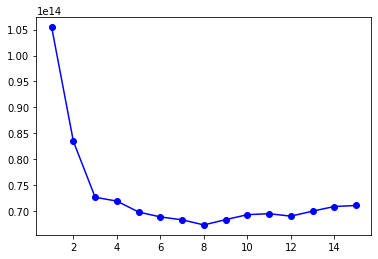

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')

***QUIZ QUESTION ***

What is the RSS on the TEST data using the value of k found above?  To be clear, sum over all houses in the TEST set.

In [84]:
np.sum((pred_output(features_test, k=8, knn_feature=features_train,knn_output=output_train) - output_test)**2)

min_idx 3758
min_idx 4670
min_idx 382
min_idx 1152
min_idx 343
min_idx 3538
min_idx 3290
min_idx 2642
min_idx 159
min_idx 1291
min_idx 1385
min_idx 4717
min_idx 1511
min_idx 3492
min_idx 5125
min_idx 3986
min_idx 5171
min_idx 837
min_idx 1431
min_idx 3786
min_idx 546
min_idx 1017
min_idx 2299
min_idx 3822
min_idx 3456
min_idx 775
min_idx 3247
min_idx 4327
min_idx 3432
min_idx 439
min_idx 1821
min_idx 118
min_idx 772
min_idx 2477
min_idx 2149
min_idx 3141
min_idx 2521
min_idx 5403
min_idx 86
min_idx 3635
min_idx 2650
min_idx 4500
min_idx 1745
min_idx 2668
min_idx 3279
min_idx 2513
min_idx 4167
min_idx 685
min_idx 1268
min_idx 4864
min_idx 649
min_idx 2675
min_idx 3862
min_idx 5368
min_idx 3496
min_idx 3593
min_idx 4573
min_idx 2641
min_idx 1035
min_idx 3851
min_idx 4402
min_idx 3811
min_idx 4027
min_idx 1527
min_idx 915
min_idx 1455
min_idx 236
min_idx 4618
min_idx 4100
min_idx 255
min_idx 359
min_idx 3430
min_idx 868
min_idx 2035
min_idx 1277
min_idx 3795
min_idx 2638
min_idx 3507
min_

min_idx 1398
min_idx 3628
min_idx 2543
min_idx 3459
min_idx 299
min_idx 1228
min_idx 1228
min_idx 303
min_idx 1508
min_idx 5469
min_idx 2217
min_idx 4434
min_idx 5069
min_idx 4416
min_idx 2548
min_idx 908
min_idx 4848
min_idx 2361
min_idx 3138
min_idx 1944
min_idx 2657
min_idx 3244
min_idx 4910
min_idx 59
min_idx 3693
min_idx 1051
min_idx 3462
min_idx 1998
min_idx 999
min_idx 548
min_idx 3681
min_idx 1884
min_idx 4701
min_idx 2925
min_idx 2807
min_idx 1712
min_idx 279
min_idx 1871
min_idx 366
min_idx 4282
min_idx 3716
min_idx 2658
min_idx 457
min_idx 1130
min_idx 139
min_idx 267
min_idx 3380
min_idx 2093
min_idx 2638
min_idx 2401
min_idx 908
min_idx 3765
min_idx 4585
min_idx 4385
min_idx 4144
min_idx 1465
min_idx 2826
min_idx 5329
min_idx 1860
min_idx 2830
min_idx 3147
min_idx 4417
min_idx 5417
min_idx 64
min_idx 4152
min_idx 2956
min_idx 758
min_idx 3896
min_idx 4392
min_idx 2425
min_idx 49
min_idx 5139
min_idx 68
min_idx 2503
min_idx 1326
min_idx 851
min_idx 3930
min_idx 2410
min_idx

min_idx 5245
min_idx 1534
min_idx 3494
min_idx 1207
min_idx 3227
min_idx 2815
min_idx 4802
min_idx 2170
min_idx 919
min_idx 1130
min_idx 1197
min_idx 3971
min_idx 4589
min_idx 5108
min_idx 3055
min_idx 3519
min_idx 1830
min_idx 562
min_idx 1084
min_idx 588
min_idx 1104
min_idx 4298
min_idx 4227
min_idx 2214
min_idx 3579
min_idx 4723
min_idx 3195
min_idx 4711
min_idx 5297
min_idx 3331
min_idx 788
min_idx 1820
min_idx 4810
min_idx 5408
min_idx 3461
min_idx 629
min_idx 1550
min_idx 820
min_idx 2525
min_idx 2877
min_idx 2372
min_idx 437
min_idx 4174
min_idx 3001
min_idx 1632
min_idx 1219
min_idx 5330
min_idx 2819
min_idx 2382
min_idx 1439
min_idx 23
min_idx 1335
min_idx 484
min_idx 857
min_idx 2569
min_idx 5369
min_idx 1775
min_idx 5248
min_idx 444
min_idx 1330
min_idx 4791
min_idx 4113
min_idx 4742
min_idx 987
min_idx 220
min_idx 967
min_idx 4932
min_idx 17
min_idx 4124
min_idx 4941
min_idx 467
min_idx 3709
min_idx 331
min_idx 3801
min_idx 271
min_idx 1150
min_idx 940
min_idx 3596
min_idx

133118823551516.81